# Enhanced OCR Model
This notebook defines an enhanced OCR model using a Convolutional Neural Network (CNN). The model is designed to recognize both handwritten digits and letters with high accuracy, using data augmentation and effective callbacks to improve performance.


In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import Library
This section imports all the necessary libraries to build, train, and evaluate the OCR model. We use TensorFlow and Keras for deep learning, Pandas for data handling, OpenCV for image processing, and Matplotlib for visualization.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
from google.colab import files
from sklearn.model_selection import train_test_split
from string import ascii_uppercase, digits
from sklearn.metrics import confusion_matrix, classification_report

## Build the Handwritten OCR Model
In this section, we define the architecture of a Convolutional Neural Network (CNN) for recognizing handwritten characters. The model includes several convolutional, pooling, and dense layers, designed to extract and classify features from input images.

In [3]:
# Define the Handwritten OCR class
# This class includes methods for building the model, training, predicting, and saving/loading the model.
class HandwrittenOCR:
    def __init__(self):
        # Initialize the model and label mapping
        self.model = self._build_model()
        self.labels = {i: char for i, char in enumerate(digits + ascii_uppercase)}
        self.image_size = 28

    def _build_model(self):
        """Build CNN model for character recognition"""
        # Using a Sequential model for simplicity
        model = tf.keras.Sequential([
            # Input layer
            tf.keras.layers.Input(shape=(28, 28, 1)),

            # First Convolutional Block
            tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.3),

            # Second Convolutional Block
            tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.3),

            # Third Convolutional Block
            tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.3),

            # Dense Layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(36, activation='softmax')  # Output layer for 36 classes
        ])

        # Compile model with updated loss function and optimizer
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            metrics=['accuracy']
        )

        return model

    def load_data(self, csv_path, mnist_include=True):
        """Load and prepare dataset from local CSV"""
        print("Loading A-Z Handwritten dataset...")
        df = pd.read_csv(csv_path)

        # Prepare A-Z dataset
        X_az = df.drop('0', axis=1).to_numpy()  # Drop label column '0'
        y_az = df['0'].to_numpy()  # Labels are in column '0'

        # Reshape and normalize A-Z data
        X_az = X_az.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        if mnist_include:
            print("Loading MNIST dataset...")
            # Load MNIST dataset
            (X_train_mnist, y_train_mnist), _ = tf.keras.datasets.mnist.load_data()
            X_train_mnist = X_train_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0

            # Combine A-Z and MNIST datasets
            X = np.concatenate((X_az, X_train_mnist), axis=0)

            # Adjust labels (A-Z: 10-35, 0-9: 0-9)
            y_az += 10  # Shift A-Z labels to avoid conflict
            y = np.concatenate((y_az, y_train_mnist), axis=0)
        else:
            X = X_az
            y = y_az

        # Convert labels to one-hot encoding
        y = tf.keras.utils.to_categorical(y, num_classes=36)

        # Split data into training and validation sets
        return train_test_split(X, y, test_size=0.2, random_state=42)

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=128):
        """Train model with data augmentation and callbacks"""
        # Data augmentation to improve generalization
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1
        )
        # Callbacks to enhance training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
        ]

        # Train the model
        history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=callbacks
        )

        return history

    def predict_image(self, image_path):
        """Predict characters in a single image"""
        # Read and preprocess image
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        # Sort contours left-to-right based on X coordinate
        contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

        results = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Filter small contours
            if w * h < 100:
                continue

            # Extract and process ROI
            roi = thresh[y:y+h, x:x+w]

            # Add padding to make square
            size = max(w, h)
            square = np.zeros((size, size), dtype=np.uint8)
            offset_x = (size - w) // 2
            offset_y = (size - h) // 2
            square[offset_y:offset_y+h, offset_x:offset_x+w] = roi

            # Resize to 28x28
            scaled = cv2.resize(square, (28, 28))

            # Prepare for prediction
            scaled = scaled.reshape(1, 28, 28, 1).astype('float32') / 255.0

            # Predict
            pred = self.model.predict(scaled, verbose=0)
            label_idx = np.argmax(pred[0])
            confidence = pred[0][label_idx]

            # Add prediction result to results list
            results.append({
                'char': self.labels[label_idx],  # Character label
                'confidence': float(confidence),  # Confidence
                'position': (x, y, w, h)  # Bounding box position
            })

        # Sort the results based on the x-coordinate (position)
        results = sorted(results, key=lambda r: r['position'][0])

        # Now concatenate the detected characters to form a string
        detected_text = ''.join([result['char'] for result in results])

        return image, detected_text, results


    def save_model(self, path):
        """Save the trained model"""
        self.model.save(path)

    def load_model(self, path):
        """Load a trained model"""
        self.model = tf.keras.models.load_model(path)

    def plot_history(self, history):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Training')
        ax1.plot(history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend()

        # Loss plot
        ax2.plot(history.history['loss'], label='Training')
        ax2.plot(history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        plt.tight_layout()
        plt.show()
# set 'factor' of tf.keras.callbacks.ReduceLROnPlateau 0.5 from 0.2
# set the optimizer='adam'

## Initialize the Model and Load Data
Here, we initialize the OCR model and load the A-Z and MNIST datasets. The datasets are preprocessed and split into training and validation sets.

Loading A-Z Handwritten dataset...
Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2703/2703 ━━━━━━━━━━━━━━━━━━━━ 151s 52ms/step - accuracy: 0.6114 - loss: 1.9533 - val_accuracy: 0.9510 - val_loss: 0.9138 - learning_rate: 0.0010
Epoch 2/50
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 183s 48ms/step - accuracy: 0.8989 - loss: 1.1010 - val_accuracy: 0.9600 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 3/50
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 128s 47ms/step - accuracy: 0.9249 - loss: 1.0052 - val_accuracy: 0.9627 - val_loss: 0.8355 - learning_rate: 0.0010
Epoch 4/50
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 128s 47ms/step - accuracy: 0.9338 - loss: 0.9660 - val_accuracy: 0.9653 - val_loss: 0.8494 - learning_rate: 0.0010
Epoch 5/50
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 134s 49ms/step - accuracy: 0.9382 - loss: 0.9442 - val_accuracy: 0.9655 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 6/50
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 133s 46ms/step - accuracy: 0.9411 - loss: 0.9297 - val_accuracy: 0.9665 - val_loss: 0.8185 - learning_rate: 0.0010
Epoch 7/50
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 134s 49ms/step - accuracy: 

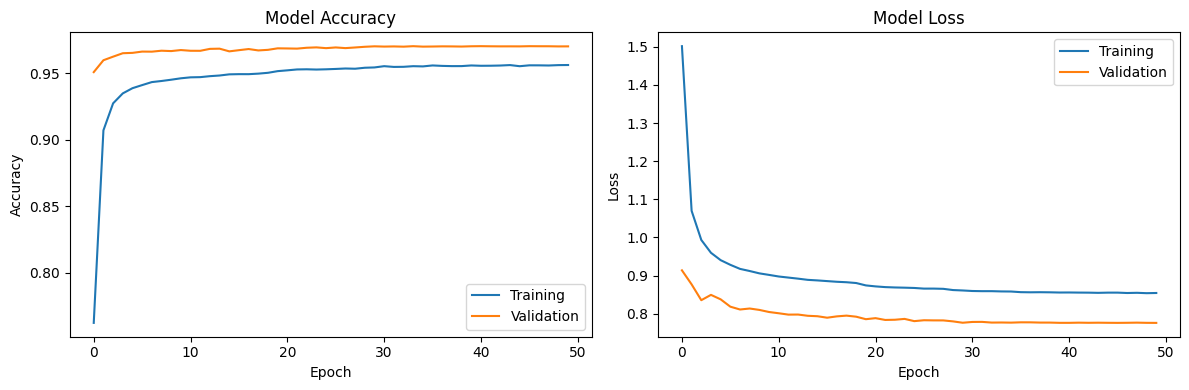

In [4]:
# Initialize the OCR model
# Load datasets and split them into training and validation sets
ocr = HandwrittenOCR()
# Load dataset
X_train, X_val, y_train, y_val = ocr.load_data('/content/drive/MyDrive/Capstone/A_Z Handwritten Data.csv')

# Train model
history = ocr.train(X_train, y_train, X_val, y_val, epochs=50)

# Plot training result
ocr.plot_history(history)

## Evaluate the Model
Perform this step after training to check the model's performance on the validation dataset, ensuring its accuracy and loss meet expectations before saving.

In [5]:
# Evaluate on the validation set
loss, accuracy = ocr.model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

2703/2703 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9709 - loss: 0.7769
Validation Loss: 0.7761
Validation Accuracy: 0.9706


In [6]:
# Predict on the validation set
y_pred = ocr.model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=ocr.labels.values()))

2703/2703 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.08      0.15      1170
           1       0.98      0.99      0.98      1349
           2       0.90      0.98      0.94      1145
           3       0.99      0.99      0.99      1228
           4       0.90      0.96      0.93      1182
           5       0.93      0.85      0.89      1101
           6       0.96      0.98      0.97      1178
           7       0.97      0.99      0.98      1247
           8       0.97      0.97      0.97      1165
           9       0.98      0.98      0.98      1185
           A       0.99      0.99      0.99      2734
           B       0.99      0.98      0.99      1713
           C       0.99      0.99      0.99      4649
           D       0.97      0.96      0.96      2042
           E       0.99      0.99      0.99      2290
           F       0.97      0.99      0.98       218
           G   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


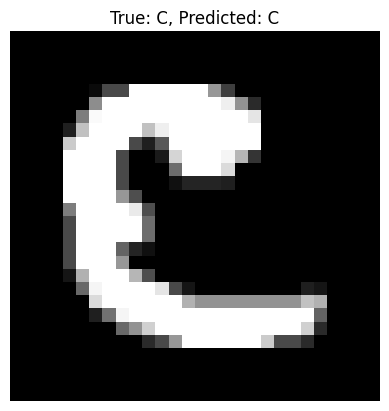

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


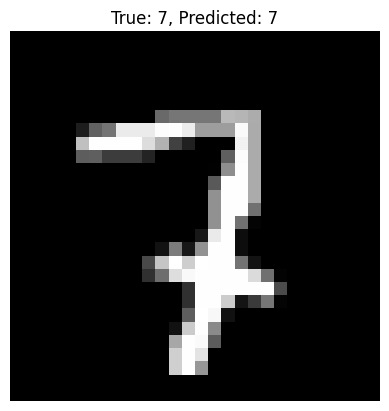

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


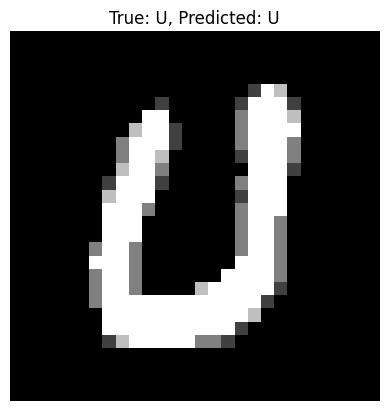

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


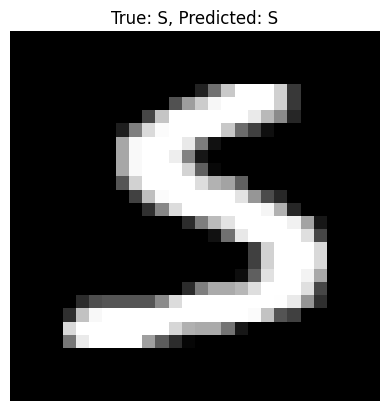

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


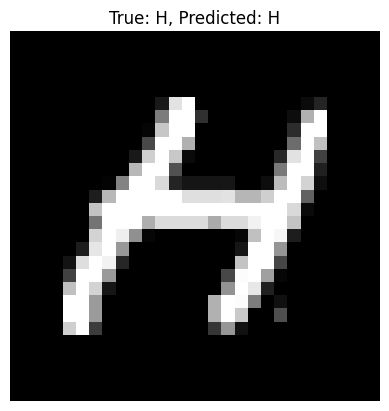

In [7]:
# Visualization of Inference Results
indices = random.sample(range(len(X_val)), 5)
for idx in indices:
    image = X_val[idx].reshape(28, 28)
    true_label = ocr.labels[np.argmax(y_val[idx])]
    predicted_label = ocr.labels[np.argmax(ocr.model.predict(X_val[idx:idx+1]))]

    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

## Save the Model
Once the model is trained, we save it for later use.

In [8]:
# Save the trained model to a file
ocr.save_model('handwritten_ocr.h5')

# Use this code to load the model
# ocr.load_model('handwritten_ocr.h5')

In [9]:
# Make sure the Accuracy still the same after save the model
ocr.load_model('handwritten_ocr.h5')
loss, accuracy = ocr.model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

2703/2703 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9709 - loss: 0.7769
Validation Loss: 0.7761
Validation Accuracy: 0.9706


## Predict Characters in an Image
In this section, we use the trained model to predict characters in a given image. The characters are extracted using image processing techniques.

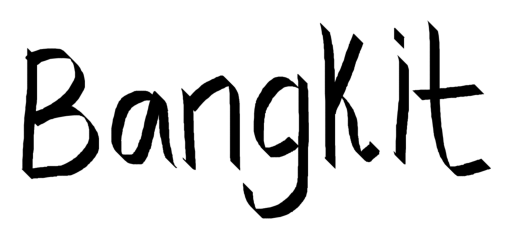

Text detection results: BMT9K1OT
character: B, Confidence: 0.82, Position: (32, 106, 208, 353)
character: M, Confidence: 0.15, Position: (273, 220, 178, 209)
character: T, Confidence: 0.15, Position: (462, 179, 159, 256)
character: 9, Confidence: 0.30, Position: (628, 175, 178, 390)
character: K, Confidence: 0.67, Position: (836, 38, 161, 393)
character: 1, Confidence: 0.98, Position: (1035, 125, 41, 294)
character: O, Confidence: 0.41, Position: (1036, 51, 28, 56)
character: T, Confidence: 0.20, Position: (1086, 32, 211, 419)


In [10]:
# Use the trained model to predict characters in an image
image, detected_text, results = ocr.predict_image('/content/Bangkit.png')

# Show image predict result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Show string result
print(f"Text detection results: {detected_text}")

# Show detail of results
for result in results:
    print(f"character: {result['char']}, "
          f"Confidence: {result['confidence']:.2f}, "
          f"Position: {result['position']}")

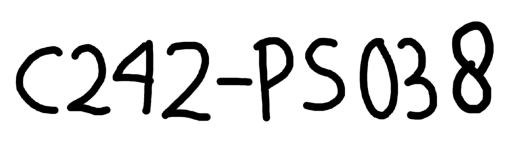

Text detection results: C242TPS038
character: C, Confidence: 0.96, Position: (20, 123, 156, 226)
character: 2, Confidence: 0.88, Position: (191, 116, 146, 237)
character: 4, Confidence: 0.53, Position: (343, 103, 139, 248)
character: 2, Confidence: 0.89, Position: (508, 109, 164, 263)
character: T, Confidence: 0.17, Position: (692, 228, 120, 27)
character: P, Confidence: 0.87, Position: (815, 93, 134, 281)
character: S, Confidence: 0.86, Position: (981, 96, 140, 243)
character: 0, Confidence: 0.51, Position: (1170, 96, 129, 271)
character: 3, Confidence: 0.88, Position: (1297, 95, 132, 273)
character: 8, Confidence: 0.91, Position: (1480, 41, 139, 306)


In [11]:
# Use the trained model to predict characters in an image
image, detected_text, results = ocr.predict_image('/content/test_model.png')

# Show image predict result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Show string result
print(f"Text detection results: {detected_text}")

# Show detail of results
for result in results:
    print(f"character: {result['char']}, "
          f"Confidence: {result['confidence']:.2f}, "
          f"Position: {result['position']}")

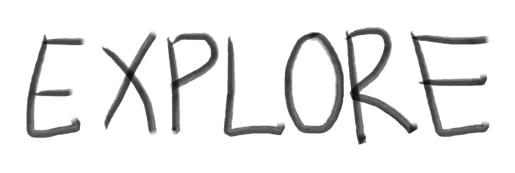

Text detection results: EXPLOKE
character: E, Confidence: 0.89, Position: (50, 76, 174, 316)
character: X, Confidence: 0.93, Position: (281, 72, 167, 307)
character: P, Confidence: 0.91, Position: (480, 73, 158, 308)
character: L, Confidence: 0.75, Position: (655, 82, 187, 307)
character: O, Confidence: 0.56, Position: (841, 71, 181, 308)
character: K, Confidence: 0.56, Position: (1025, 56, 223, 357)
character: E, Confidence: 0.49, Position: (1226, 67, 242, 322)


In [12]:
# Use the trained model to predict characters in an image
image, detected_text, results = ocr.predict_image('/content/explore.png')

# Show image predict result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Show string result
print(f"Text detection results: {detected_text}")

# Show detail of results
for result in results:
    print(f"character: {result['char']}, "
          f"Confidence: {result['confidence']:.2f}, "
          f"Position: {result['position']}")

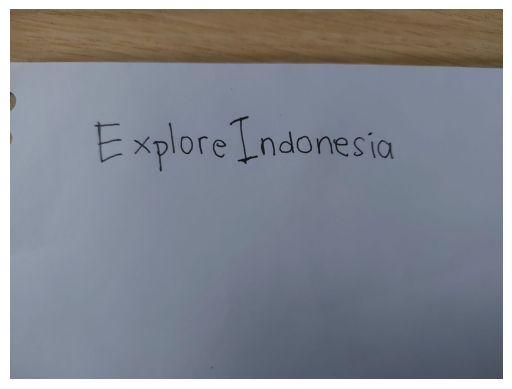

Text detection results: 1ATEXP1O7OTC1T2OMCLSO1QPT
character: 1, Confidence: 0.51, Position: (0, 399, 7, 37)
character: A, Confidence: 0.50, Position: (0, 269, 20, 60)
character: T, Confidence: 0.87, Position: (0, 0, 1600, 193)
character: E, Confidence: 0.88, Position: (274, 365, 92, 134)
character: X, Confidence: 0.95, Position: (402, 413, 54, 58)
character: P, Confidence: 0.90, Position: (463, 427, 50, 100)
character: 1, Confidence: 0.98, Position: (515, 368, 21, 100)
character: O, Confidence: 0.63, Position: (553, 413, 41, 58)
character: 7, Confidence: 0.20, Position: (560, 1176, 16, 24)
character: O, Confidence: 0.47, Position: (578, 792, 1022, 408)
character: T, Confidence: 0.59, Position: (610, 412, 33, 59)
character: C, Confidence: 0.58, Position: (658, 423, 44, 60)
character: 1, Confidence: 0.39, Position: (712, 347, 93, 156)
character: T, Confidence: 0.18, Position: (814, 416, 48, 60)
character: 2, Confidence: 0.37, Position: (874, 397, 49, 71)
character: O, Confidence: 0.78, P

In [13]:
# Use the trained model to predict characters in an image
image, detected_text, results = ocr.predict_image('/content/expid.jpg')

# Show image predict result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Show string result
print(f"Text detection results: {detected_text}")

# Show detail of results
for result in results:
    print(f"character: {result['char']}, "
          f"Confidence: {result['confidence']:.2f}, "
          f"Position: {result['position']}")

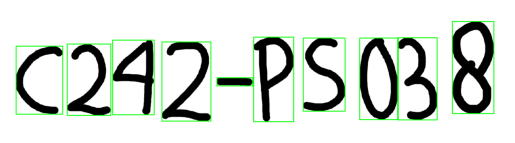

Hasil deteksi teks: C242TPS038


In [14]:
# Use the trained model to predict characters in an image
image, detected_text, results = ocr.predict_image('/content/test_model.png')

# Building box at each characters
for result in results:
    x, y, w, h = result['position']
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box

# Show the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print the result
print(f"Hasil deteksi teks: {detected_text}")

In [15]:
model_json = ocr.model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

with open("label_mapping.json", "w") as label_file:
    json.dump(ocr.labels, label_file)

In [16]:
def convert_model_to_json(model, labels, history, X_val, y_val):
    # Evaluate model performance
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

    # Convert model details to JSON
    model_config = {
        "model_info": {
            "input_shape": model.input_shape[1:],
            "output_shape": model.output_shape[1:],
            "total_layers": len(model.layers)
        },
        "performance": {
            "validation_loss": float(loss),
            "validation_accuracy": float(accuracy)
        },
        "training_history": {
            "accuracy": history.history['accuracy'],
            "val_accuracy": history.history['val_accuracy'],
            "loss": history.history['loss'],
            "val_loss": history.history['val_loss']
        },
        "label_mapping": labels
    }

    # Save JSON file
    import json
    with open('/content/handwritten_ocr_model.json', 'w') as f:
        json.dump(model_config, f, indent=4)

    print("Model converted and saved in /content/handwritten_ocr_model.json")
    return model_config

# Usage after training
model_json = convert_model_to_json(ocr.model, ocr.labels, history, X_val, y_val)

Model converted and saved in /content/handwritten_ocr_model.json


In [17]:
#from google.colab import drive
#drive.mount('/content/drive')